<a href="https://colab.research.google.com/github/Santhosh-2308/AIRL-Assignment/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done


Saving d.jpeg to d (13).jpeg
Enter object to segment (e.g. 'a dog', 'a tree'): a dog


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


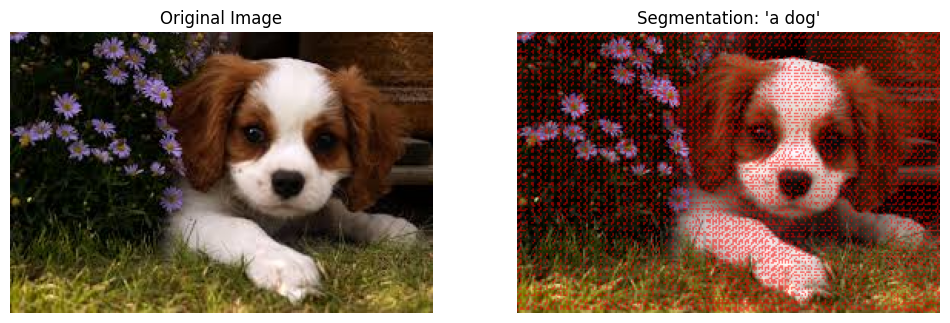

In [ ]:
# ========================================
# 🛠️ Install dependencies
# ========================================
!pip install -q torch torchvision transformers pillow matplotlib opencv-python huggingface_hub
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

# ========================================
# 📦 Imports
# ========================================
import torch
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from huggingface_hub import hf_hub_download
from google.colab import files
from segment_anything import sam_model_registry, SamPredictor

# ========================================
# 🖼️ Upload image
# ========================================
uploaded = files.upload()
for filename in uploaded.keys():
    image_pil = Image.open(filename).convert("RGB")
    image_pil.show()
    image_path = filename

image_np = np.array(image_pil)

# ========================================
# 💬 Text prompt
# ========================================
text_prompt = input("Enter object to segment (e.g. 'a dog', 'a tree'): ")

# ========================================
# 🧠 Load CLIPSeg model to generate seeds
# ========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

inputs = processor(text=[text_prompt], images=[image_pil], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = clipseg_model(**inputs)
pred = torch.sigmoid(outputs.logits)[0][0].cpu().numpy()

# Resize prediction to image size
pred_resized = np.array(Image.fromarray(pred).resize(image_pil.size, resample=Image.BILINEAR))

# ========================================
# 🌱 Generate seed points for SAM
# ========================================
threshold = 0.05  # very low threshold to capture all object pixels
seed_mask = (pred_resized > threshold).astype(np.uint8)

ys, xs = np.where(seed_mask > 0)
points = np.stack([xs, ys], axis=-1)
point_labels = np.ones(len(points))  # foreground labels

# Optional: sample max 500 points if too many
if len(points) > 500:
    idx = np.random.choice(len(points), 500, replace=False)
    points = points[idx]
    point_labels = point_labels[idx]

# ========================================
# 🧩 Download SAM 2 checkpoint automatically
# ========================================
checkpoint_path = hf_hub_download(
    repo_id="facebook/sam2-hiera-large",
    filename="sam2_hiera_large.pt"
)

# ========================================
# 🧠 Load SAM 2 model
# ========================================
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = ckpt["model"] if "model" in ckpt else ckpt

sam = sam_model_registry["vit_h"]()
sam.load_state_dict(state_dict, strict=False)
sam.to(device)
predictor = SamPredictor(sam)
predictor.set_image(image_np)

# ========================================
# 🔍 SAM prediction
# ========================================
masks, scores, logits = predictor.predict(
    point_coords=points,
    point_labels=point_labels,
    multimask_output=False
)

# ========================================
# 🎨 Overlay the final mask (filled red)
# ========================================
mask = masks[0].astype(bool)
overlay = image_np.copy()
overlay[mask] = (0.5 * image_np[mask] + 0.5 * np.array([255, 0, 0])).astype(np.uint8)

# ========================================
# 📊 Display results
# ========================================
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(image_np)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Segmentation: '{text_prompt}'")
plt.show()
